<center><img src="https://datascientest.fr/train/assets/logo_datascientest.png", style="height:150px"/></center>

<hr style="border-width:2px;border-color:#75DFC1">

<center><img src="https://assets-datascientest.s3.eu-west-1.amazonaws.com/logo+SatisPy+Project.png", style="height:150px"/></center>

<center><h1> Vectorisation & Filtrage de la cible *Commentaire* </h1></center>

### Import des packages et versions utilisées

In [45]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from time import time
import re 
from collections import Counter
import nltk
from nltk.corpus import stopwords                                
# fonction stop_words_filtering crée pour bibliotheque de mots à stopper perso
nltk.download('stopwords')

import spacy

import gensim
# from gensim.models import keyedvectors
from gensim.models.keyedvectors import load_word2vec_format
from gensim.test.utils import datapath


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UserPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)
print('NaturaLanguageTooKit  : ' + nltk.__version__)        
print('Gensim                : ' + '4.1.2')                 
print('wikipedia2vec         : ' + '1.0.5')


Version des librairies utilisées :
Python                : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.5
Pandas                : 1.4.2
Seaborn               : 0.11.2
NaturaLanguageTooKit  : 3.7
Gensim                : 4.1.2
wikipedia2vec         : 1.0.5


### paramétrage de l'affichage

In [47]:
# préparation de l'affichage des dataframes => même fonction que le notebook data_explo à séparer dans un outils.py à importer

dico_pd_option = {
    'display.max_rows': 100,    # nbre max de lignes 
    'display.max_column': 50,  # nbre max de colonnes
    'display.width': 100,       # largeur lignes 
    'display.precision': 2,     # precision des valeurs
    'display.max_colwidth': 100  # largeurs colonnes
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)
    
pd.options.display.float_format = "{:,.3f}".format  # affichage pd float à 3 décimales


### Chargement du fichier de sauvegarde en Français traité par langid précédemment

In [48]:
# importer les données nettoyées
data = pd.read_csv('reviews_trust_fr_VF.csv', sep=',')  
data.drop(data.iloc[:,:1], axis=1, inplace=True)


## Choix de numérisation des étoiles 'star'

In [49]:
new_star = {1:0,2:0,3:1,4:1,5:1}
data.star.replace(new_star,inplace = True)

""" voir proportions des 0 et 1 """
print('les proportion des 0 et 1')
display(data.star.value_counts()*100/data.shape[0])    

data.sample(1)

les proportion des 0 et 1


1   65.556
0   34.444
Name: star, dtype: float64

,Commentaire,star,source,company,index_org,star_org,date
10501,très beau article de qualité mais taille petit c est dommage,1,TrustedShop,ShowRoom,12931,4,2020-07-01


## Nettoyage du corpus

In [50]:
# récupérer colonne 'Commentaire' sous forme de liste de str dans corpus
corpus = data['Commentaire'].tolist()                                          
print(corpus[0])


bonjour , ca doit faire 5 ans environ que je suis membre showrooprive . je n ’ ai jamais eu de soucis en particulier à part 2/3 petites bricoles…par contre depuis ces 3 derniers mois , une vraie catastrophe ! j ’ ai eu 3 commandes annulées d ’ affiliés… à se demander si les ventes sont bien réelles histoires de nous faire payer et que showroom « joue » avec notre argent en se faisant des intérêts bancaires sur notre dos ! ! ! ! la 1 ère commande « machines et cafés » 89,99€… annulé 1 mois après …la 2e commande « don ’ t call me jennifer » 65,16€… annulé 1 mois après …la 3e commande « techwood » 46,29€… annulé 1 mois après….je l ’ apprends toujours par mail…le même message « bateau » « malgré tous les efforts… .. bla-bla-bla bien évidemment , pas de dédommagement ! ! ! ! ben . non , hein , pourquoi faire ? ! ? ! je doute que ce site soit aussi fiable et sérieux qu ’ au début ! au final je vais juste rester fidèle sur n autre site marchand ! ! ! ! ! très décevant … plus du tout confiance

### Probleme r a s , r a d,  ras, rad, r.a.s et r.a.d et variantes avec 'à' au lieu du 'a' + problème lié de 'ras le bol'
- En parcourant les verbatims aléatoirement de nombreuses fois, nous avons remarqué le problème suivant :
   - beaucoup de commentaires contiennent juste l'expression 'ras' pour 'rien à signaler' et leurs  variantes avec espace et le lettre 'à' au lieu de la lettre 'a', un point ou un espace séparant le r, a et s et parfois même un d remplaçant le r pour "rien à dire ".
   - cela pose un probleme de filtrage à venir où on souhaite éliminer tous les mots de moins de 4 lettre (<=3) car il ne resterait plus aucun commentaire pour nos prédiction
   - de plus ce raccourcis 'ras' donne une notation toujours positive au message, la prédiction est donc aisée
   - un autre problème a été remarqué avec la présence de nombreux 'ras le bol' qui est un sentiment négatif et serait aussi éliminé pour notre filtre de moins de 4 caractères
   
- la partie de code qui suit nous sert à filtrer toutes les combinaisons possibles de 'ras' et de 'ras le bol' => nous trouveront 2.2% du data_set concerné ce qui n'est pas négligeable
- puis nous procèreront au remplacement de ces mots comme il convient par 'bien' pour les 'ras' et 'mauvais' pour les 'ras le bol' afin de ne pas vider de lignes de tokens et ajouter un sentiment fort
- un tableau boolean des résultats avec les commentaires associés nous permet de vérifier nos résultats au fur et à mesure.
- nous ne présentons pas ici tous les résultats intermédiaires, mais le code en substance pour montrer notre procédure
- enfin, cette partie pourra être détachée ou ne sera plus utile pour la suite, sauf à construire une fonction de traitement qui fera une conversion automatique pour tout commentaire à venir

### Fonction de conversion d'une liste de listes en 1 seule liste

In [51]:
# convertion d'une liste de liste en 1 seule liste 
def extend_list(my_list, res=None):
    if res is None:
        res = []
    for obj in my_list:
        if isinstance(obj, (list, tuple)):
            extend_list(obj, res)
        else:
            res.append(obj)
    return res

In [52]:
# trouver tous les ras sans espace et variantes et les afficher 

# compilateur regex pour 'ras' ràs' 'rad' et 'ràd'
re_ras = re.compile(r"\bras\b|\bràs\b|\brad\b|\bràd\b")   

list_ras = []  
for ele in corpus:                
    list_ras.append(re_ras.findall(ele))
    # print(re_ras.findall(ele)) 
    
# affichage des fréquences trouvées
list_extend = extend_list(list_ras)
list_freq = Counter(list_extend)
print(list_freq)

# convertir list_ras en liste boolean pour indexing de notre data et vérification des étoiles star liées aux commentaires ras et variantes
list_bool_ras = []
for row in list_ras:                                                          
    if len(row)!=0:
        list_bool_ras.append(True)
    else:
        list_bool_ras.append(False)
        
print("Counter list_bool_ras_true =",list_bool_ras.count(True))                                                          # -> 367 True ras ou rad  !!!  OK BON

Counter({'ras': 356, 'rad': 4})
Counter list_bool_ras_true = 360


In [53]:
# compilateur regex pour 'r a s' r à s' 'r a d' et 'r à d'
re_r_a_s = re.compile(r"[r]+[\s]+[a|à]+[\s]+[s|d]$")  

list_r_a_s = []  
for ele in corpus:                
    list_r_a_s.append(re_r_a_s.findall(ele))
    # print(re_r_a_s.findall(ele)) 
    
# affichage des fréquences trouvées
list_extend = extend_list(list_r_a_s)
list_freq = Counter(list_extend)
print(list_freq)

# convertir list_ras en liste boolean pour indexing de notre data et vérification des étoiles star liées aux commentaires ras et variantes
list_bool_r_a_s = []
for row in list_r_a_s:                                                          
    if len(row)!=0:
        list_bool_r_a_s.append(True)
    else:
        list_bool_r_a_s.append(False)
        
print("Counter list_bool_r_a_s_true =",list_bool_r_a_s.count(True))                                                          # -> 7 True r a s ou r a d  !!!  OK BON

Counter({'r a s': 5, 'r à s': 2})
Counter list_bool_r_a_s_true = 7


In [54]:
# compilateur regex pour 'ras le bol'
re_raslebol = re.compile(r"(ras le bol)+")

list_raslebol = []  
for ele in corpus:              
    list_raslebol.append(re_raslebol.findall(ele))
    # print(re_ras.findall(ele)) 
    
# affichage des fréquences trouvées
list_extend = extend_list(list_raslebol)
list_freq = Counter(list_extend)
print(list_freq)

# convertir list_ras en liste boolean pour indexing de notre data et vérification des étoiles star liées aux commentaires ras et variantes
list_bool_raslebol = []
for row in list_raslebol:                                                        
    if len(row)!=0:
        list_bool_raslebol.append(True)
    else:
        list_bool_raslebol.append(False)
        
print("Counter list_bool_raslebol_true =",list_bool_raslebol.count(True))                                                          # -> 16 True 'ras le bol'

Counter({'ras le bol': 16})
Counter list_bool_raslebol_true = 16


In [55]:
# fusion des 2 tableaux boolean des ras et r a s
list_fin = [True if ((list_bool_ras[i]==True)|(list_bool_r_a_s[i]==True)) else False for i in range(len(list_bool_ras))]
list_fin.count(True)  # 374 = 367 + 7 ok

# vérification des étoiles star associées au bool True de ras rad r a s etc...
data['mask_ras'] = list_fin
data_ras = data.loc[data['mask_ras']==True]
print("data_ras.shape = ",data_ras.shape)
# data_ras.head(20)

data_ras.shape =  (367, 8)


In [56]:
# Analyse des ras avec étoile = 0 = mauvais
print(" nombre de ligne avec 'ras' et étoile 0 (mauvaise notation) = ", data_ras.loc[data_ras['star']==0].shape[0])
data_ras.loc[data_ras['star']==0].head(3)

 nombre de ligne avec 'ras' et étoile 0 (mauvaise notation) =  16


,Commentaire,star,source,company,index_org,star_org,date,mask_ras
598,très déçu de mon expérience .... commande numéro 213999306 jamais reçu ( aurrai du arriver le 4/...,0,TrustPilot,ShowRoom,638,1,2021-01-03 00:00:00+00:00,True
610,"site qui devient catastrophique depuis quelques temps , il manque des articles dans les commande...",0,TrustPilot,ShowRoom,650,1,2020-12-31 00:00:00+00:00,True
708,toujours pas de remboursement le statut de ma commande est tjs expédiée et le colis n ’ est jama...,0,TrustPilot,ShowRoom,748,1,2020-12-16 00:00:00+00:00,True


In [57]:
""" faire varier le head() ou passer en sample(20) pour observer les différents cas, le head(20) donne essentiellement des 'ras le bol' plutot que des ras ici """

" faire varier le head() ou passer en sample(20) pour observer les différents cas, le head(20) donne essentiellement des 'ras le bol' plutot que des ras ici "

In [58]:
'''
#la méthode apply&lambda fonctionne aussi
il y une illustration avec des analyses de sentiment
'''
# problème de "ras, ràs, rad, ràd, ras le bol"
data2 = pd.read_csv('reviews_trust_fr_VF.csv', sep=',')  
data2.drop(data2.iloc[:,:1], axis=1, inplace=True)
new_star = {1:0,2:0,3:1,4:1,5:1}
data2.star.replace(new_star,inplace = True)
re_ras = re.compile(r"\bras\b|\bràs\b|\brad\b|\bràd\b")
re_r_a_s = re.compile(r"[r]+[\s]+[a|à]+[\s]+[s|d]$")
re_raslebol = re.compile(r"(ras le bol)+")
data2['pb_rasd']=data2['Commentaire'].apply(lambda x: len(re_ras.findall(x)))
data2['pb_r_a_s_d']=data2['Commentaire'].apply(lambda x: len(re_r_a_s.findall(x)))
data2['pb_raslebol']=data2['Commentaire'].apply(lambda x: len(re_raslebol.findall(x)))
data2['pb_rasd'] = data2['pb_rasd']+data2['pb_r_a_s_d']

## Analyser les sentiments des "ras rad ..."

C:\Users\UserPC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


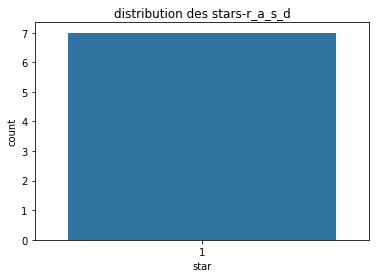

In [59]:
sns.countplot(data2[data2['pb_r_a_s_d'] != 0]['star'] ).set(title = 'distribution des stars-r_a_s_d');

C:\Users\UserPC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


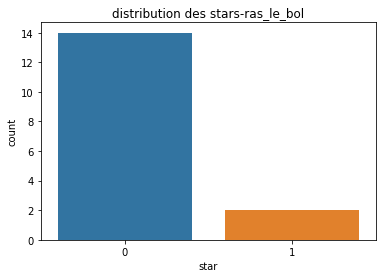

In [60]:
sns.countplot(data2[data2['pb_raslebol'] != 0]['star'] ).set(title = 'distribution des stars-ras_le_bol');

- On remarque que les mauvaise notations viennent de 'ras ' suivi de 'le bol' qui est bien une mauvaise notation contrairement à 'ras' seul qui est une bonne notation
- les conversions de 'ras' ou 'r a s' et variante en 'bien' permettront de confirmer une bonne notation
- les conversions de 'ras le bol' en mauvais permetttront de confirmer une mauvaise notation
- ces conversions permettent aussi un filtre par la suite pour éliminer les mots <= à 3 caractères ( ce qui aurait éliminé 'ras' et 'ras le bol' sans distinction

### conversion des ras et ras le bol
- cette conversion doit nous aider à fabriquer notre fonction de filtrage et conversion automatique de ces mots

In [62]:
# les 4 regex vus ci-dessus rappelés ici
re_ras_points = re.compile(r"(r.a.s)|(r.à.s)|(r.a.d)|(r.à.d)") # pb r.a.s, r.à.s, r.a.d et r.à.d 
re_r_a_s = re.compile(r"[r]+[\s]+[a|à]+[\s]+[s|d]$")      # pb r a s , r a d , r à s , r à d
re_ras = re.compile(r"\bras\b|\bràs\b|\brad\b|\bràd\b")   # pb ras , rad , ràs , ràs
re_raslebol = re.compile(r"(ras le bol)+")                # pb ras le bol

start = time()
corpus_ras_le_bol = []
for ele in corpus:
    result = re_raslebol.sub('mauvais', ele)
    corpus_ras_le_bol.append(result) 
end = time()
print("temps écoulé = ",end-start)


# trouver les 'r.a.s' ou 'r.à.s' ou 'r.a.d' ou 'r.à.d' et convertir en 'bien'
start = time()
corpus_ras = []
for ele in corpus_ras_le_bol:                          # list_test remplacé par corpus pour test     OK BON
    result = re_ras_points.sub('bien', ele)
    corpus_ras.append(result)
end = time()
print("temps écoulé = ",end-start)

    
# trouver les 'r a s ' ou  ' r à s' ou 'r à d' ou 'r a d' et convertir en 'bien'
start = time()
corpus_ras2 = []
for ele in corpus_ras:                          # list_test remplacé par corpus pour test     OK BON
    result = re_r_a_s.sub('bien', ele)
    corpus_ras2.append(result)
end = time()
print("temps écoulé = ",end-start)

# trouver les 'ras' ou 'ràs' ou 'rad' ou 'ràd' et convertir en 'bien'
start = time()
corpus_ras3 = []
for ele in corpus_ras2:                          # list_test remplacé par corpus pour test     OK BON
    result = re_ras.sub('bien', ele)
    corpus_ras3.append(result)
end = time()
print("temps écoulé = ",end-start)

# remplacement 'ras',  'r a s' et 'ras le bol' terminé à ce stade  ET commentaires traités placés dans 'corpus_ras3' 
# bascule du traitement dans corpus
corpus = corpus_ras3

temps écoulé =  0.387998104095459
temps écoulé =  0.5400333404541016
temps écoulé =  0.1529998779296875
temps écoulé =  0.4239993095397949


In [63]:
# vérification avec lignes intéressantes remarquées sur data_ras
print("non traité : ", data.Commentaire[17089], " et traité : ",corpus[17089])  # exemple 'r.a.s'
print("non traité : ", data.Commentaire[5918], " et traité : ",corpus[5918])    # exemple ' r à s '
print("non traité : ", data.Commentaire[5217], " et traité : ",corpus[5217])    # exemple ' ras'
print("non traité : ", data.Commentaire[14727], " et traité : ",corpus[14727])  # exemple 'ras le bol '

non traité :  r.a.s  et traité :  bien
non traité :  r à s  et traité :  bien
non traité :  qualité vêtements très moyenne ! ! ! autrement ras  et traité :  qualité vêtements très moyenne ! ! ! autrement bien
non traité :  un abonnement que j aurais du recevoir il y a deux mois .... et tjrs rien.le service abonnement me dit qu il n ont pas de trace de mon paiement et veepe me dit qu ils vont se renseigner .... ras le bol ! ! ! ! ! ! !  et traité :  un abonnement que j aurais du recevoir il y a deux mois .... et tjrs rien.le service abonnement me dit qu il n ont pas de trace de mon paiement et veepe me dit qu ils vont se renseigner .... mauvais ! ! ! ! ! ! !


In [64]:
data.head(3)

,Commentaire,star,source,company,index_org,star_org,date,mask_ras
0,"bonjour , ca doit faire 5 ans environ que je suis membre showrooprive . je n ’ ai jamais eu de s...",0,TrustPilot,ShowRoom,0,1,2021-06-20 00:00:00+00:00,False
1,vente lacoste article manquant photo prise sur 6 articles la moitié livrée sans explication manq...,0,TrustPilot,ShowRoom,1,1,2021-06-20 00:00:00+00:00,False
2,"vente lacoste honteuse , article erroné , article manquant , pas de bon de livraison , retard et...",0,TrustPilot,ShowRoom,2,1,2021-06-19 00:00:00+00:00,False


## Tokenisation corpus_tk
- stop ponctuations, nombres et smileys et liste de mots en laissant tous les accents et lettres spéciales minuscules


In [65]:
# compiler et création liste de liste de token dans corpus_tk
start = time()
re_token = re.compile(r"[^a-zéèêàâîïàùçôëûæœ]+")                                
corpus_tk=[]
for line in corpus:
    corpus_tk.append(re_token.split(line))                                    

end = time()
print("temps écoulé = ",end-start)

# ajout colonne token à data
data['tokens'] = pd.Series(corpus_tk)
#  décompte des token 
total = []
for i in range(data.shape[0]):
    total.append(len(data['tokens'][i]))
    
# ajout de la colonne du total des tokens restants    
data['total1'] = total   
print("1er total des mots après tokenisation : ", data.total1.sum())            # 691.347 MOTS total 1  
   
# affichage de data
data.sample(2)


temps écoulé =  0.5739998817443848
1er total des mots après tokenisation :  691347


,Commentaire,star,source,company,index_org,star_org,date,mask_ras,tokens,total1
13113,jusqu ' à aujourd'hui je n'ai pas encore reçu mon colis je n'ai suis pas contacté si c ' c'est a...,0,TrustedShop,ShowRoom,16102,1,2020-06-12,False,"[jusqu, à, aujourd, hui, je, n, ai, pas, encore, reçu, mon, colis, je, n, ai, suis, pas, contact...",31
15085,site de confiance . délais de livraison un peu longs,1,TrustPilot,VeePee,18300,4,2019-06-08 00:00:00+00:00,False,"[site, de, confiance, délais, de, livraison, un, peu, longs]",9


In [67]:
# élimination des token vides créés après tokenisation à cause des ! ! ! par exemple
clean_tk = []
for row_list in corpus_tk:
    clean_tk.append([ele for ele in row_list if len(ele) != 0])
    
# verif total token restant
serie_clean_tk = pd.Series(clean_tk)
#  décompte des token 
total = []
for i in range(data.shape[0]):
    total.append(len(serie_clean_tk[i]))
    
# calcul du total des tokens restants    
total_clean_tk = pd.Series(total) 
print("2sd total des mots après élimination des tokens vides : ", total_clean_tk.sum())                     

# pas de nouvelle colonne crée dans data donc réafectation de clean_tk dans corpus_tk    
corpus_tk = clean_tk   


2sd total des mots après élimination des tokens vides :  682825


### Vérification visuelle de tous les tokens en 1 seule chaine STR

In [68]:
# Combiner toutes les String de la liste
corpus_tk_list = extend_list(corpus_tk)
verif_corpus_tk = ' '.join(corpus_tk_list)
print("nombre de caractères au total = ", len(verif_corpus_tk))
# affichage d'une partie de la chaine totale ( modifiable à volonté pour vérif )
verif_corpus_tk[:2000]  # ici les 2000 1er caractères affichés 

nombre de caractères au total =  3721753


'bonjour ca doit faire ans environ que je suis membre showrooprive je n ai jamais eu de soucis en particulier à part petites bricoles par contre depuis ces derniers mois une vraie catastrophe j ai eu commandes annulées d affiliés à se demander si les ventes sont bien réelles histoires de nous faire payer et que showroom joue avec notre argent en se faisant des intérêts bancaires sur notre dos la ère commande machines et cafés annulé mois après la e commande don t call me jennifer annulé mois après la e commande techwood annulé mois après je l apprends toujours par mail le même message bateau malgré tous les efforts bla bla bla bien évidemment pas de dédommagement ben non hein pourquoi faire je doute que ce site soit aussi fiable et sérieux qu au début au final je vais juste rester fidèle sur n autre site marchand très décevant plus du tout confiance je ne recommande plus du tout ce site et j en fais part à mon entourage et réseaux sociaux afin d éviter que d autres personnes connaissen

## Lemmatisation des mots Français

- test lemmatisation avant lancement sur corpus

In [69]:
# utilisation du module spacy importé

In [70]:
nlp = spacy.load('fr_core_news_md')

doc = nlp(u"voudrais non animaux yeux dors couvre.")
for token in doc:
    print(token, token.lemma_) 
    
doc2 = nlp(" ".join(corpus_tk[1]))
for token in doc2:
    print(token, token.lemma_)


voudrais vouloir
non non
animaux animal
yeux yeux
dors dormir
couvre couvrir
. .
vente vente
lacoste lacost
article article
manquant manquant
photo photo
prise prendre
sur sur
articles article
la le
moitié moitié
livrée livrer
sans sans
explication explication
manque manqu
de de
respect respect
numero numero
de de
commande commande


In [71]:
# Lemmatisation sur vrai data_set corpus_mot

start = time()
corpus_lem = []
for line_com in corpus_tk:
    liste = []
    doc = nlp(" ".join(line_com))
    for token in doc:
        liste.append(token.lemma_)
    corpus_lem.append(liste)     
end = time()
print("temps écoulé = ", end-start)                                             # LEMMATISATION TEMPS environ 6 MINUTES !!!

temps écoulé =  416.840270280838


In [72]:
data['lemmatiser'] = pd.Series(corpus_lem)
#  décompte des token 
total = []
for i in range(data.shape[0]):
    total.append(len(data['lemmatiser'][i])) 
# ajout de la colonne du total des mots lemmentisés   
data['tot_lem'] = total   
print("total des mots après lemmatisation : ", data.tot_lem.sum())               # 682.825  total lemmatisation
data.sample(10)

total des mots après lemmatisation :  682825


,Commentaire,star,source,company,index_org,star_org,date,mask_ras,tokens,total1,lemmatiser,tot_lem
4148,commande non conforme ce n est pas ce sac que j ai commandé donc retour merci,1,TrustedShop,ShowRoom,5222,3,2020-12-05,False,"[commande, non, conforme, ce, n, est, pas, ce, sac, que, j, ai, commandé, donc, retour, merci]",16,"[commande, non, conforme, ce, n, être, pas, ce, sac, que, j, avoir, commander, donc, retour, merci]",16
15315,site de vente avec des faux prix . il ont etait epinglé a se sujet . sav pas serieux du tout,0,TrustPilot,VeePee,18557,1,2019-03-04 00:00:00+00:00,False,"[site, de, vente, avec, des, faux, prix, il, ont, etait, epinglé, a, se, sujet, sav, pas, serieu...",19,"[site, de, vente, avec, un, faux, prix, il, avoir, etait, epinglé, avoir, se, sujet, sav, pas, s...",19
14240,"site sérieux avec une grande diversité de produits et de bonne qualité , il arrive parfois qu ’ ...",1,TrustPilot,VeePee,17425,4,2020-08-08 00:00:00+00:00,False,"[site, sérieux, avec, une, grande, diversité, de, produits, et, de, bonne, qualité, il, arrive, ...",87,"[site, sérieux, avec, un, grand, diversité, de, produit, et, de, bon, qualité, il, arrive, parfo...",86
16881,ras,1,TrustedShop,ShowRoom,9590,5,2020-07-31,True,[bien],1,[bien],1
8190,il manque un article dans la commande sans possibilité de me le renvoyer alors que j ’ ai été dé...,0,TrustedShop,ShowRoom,10208,2,2020-07-24,False,"[il, manque, un, article, dans, la, commande, sans, possibilité, de, me, le, renvoyer, alors, qu...",22,"[il, manque, un, article, dans, le, commande, sans, possibilité, de, me, le, renvoyer, alors, qu...",22
14389,retour d'article compliquétout sur fait pour vous dissuader de renvoyer l'article-l'option de re...,0,TrustPilot,VeePee,17575,1,2020-06-27 00:00:00+00:00,False,"[retour, d, article, compliquétout, sur, fait, pour, vous, dissuader, de, renvoyer, l, article, ...",57,"[retour, d, article, compliquétout, sur, fait, pour, vous, dissuader, de, renvoyer, l, article, ...",57
14450,il y a beaucoup de mensonge lorsqu'on veut annuler des articles luxueux . impossible de renvoyer...,0,TrustPilot,VeePee,17637,1,2020-06-11 00:00:00+00:00,False,"[il, y, a, beaucoup, de, mensonge, lorsqu, on, veut, annuler, des, articles, luxueux, impossible...",72,"[il, y, avoir, beaucoup, de, mensonge, lorsqu, on, vouloir, annuler, un, article, luxueux, impos...",71
1011,"c'est le comble .j'ai commandé des écouteurs sans fil , et a la place je reçois une vitre pour i...",0,TrustPilot,ShowRoom,1054,1,2020-10-12 00:00:00+00:00,False,"[c, est, le, comble, j, ai, commandé, des, écouteurs, sans, fil, et, a, la, place, je, reçois, u...",75,"[c, être, le, comble, j, avoir, commander, un, écouteur, sans, fil, et, avoir, le, place, je, re...",75
14713,vraiment pas sérieux du tout annule des commande sans prévenir long a se faire rembourser grosse...,0,TrustPilot,VeePee,17924,1,2020-01-12 00:00:00+00:00,False,"[vraiment, pas, sérieux, du, tout, annule, des, commande, sans, prévenir, long, a, se, faire, re...",28,"[vraiment, pas, sérieux, de, tout, annule, de, commande, sans, prévenir, long, avoir, se, faire,...",27
2377,très contente de mes commande merci beaucoup,1,TrustedShop,ShowRoom,2598,5,2021-05-17,False,"[très, contente, de, mes, commande, merci, beaucoup]",7,"[très, content, de, mon, commande, merci, beaucoup]",7


- la lemmatisation marche bien es, est sommes = être, ai, a as = avoir, la, les = le etc...
- problème pour 'j' ne devient pas 'je' mais pas grave puisque élimination moins de 3 lettres ensuite
- les verbre passent tous à l'infinitif ...

In [73]:
""" lemmatiser prend du temps => voir pour sauvegarde """
data.to_csv('review_trust_fr_lemmantiser_VF-20-09-22.csv')

### retirer les tokens de moins de 2 lettres

In [74]:
# retirer les tokens de moins de 2 lettres
corpus_sw = [[mot for mot in line_com if len(mot) > 2] for line_com in corpus_lem]  
# ajouter colonne résultat à data
corpus_sw_serie = pd.Series(corpus_sw)
data['words+2'] = corpus_sw_serie
#  décompte des tokens restants 
total = []
for i in range(data.shape[0]):
    total.append(len(data['words+2'][i])) 
# ajout de la colonne du total des tokens restants    
data['tot_+2'] = total    

print("total des mots après filtrage mots de 2 lettres ou + : ", data['tot_+2'].sum())  # 464.241 mots
data.sample(1)

total des mots après filtrage mots de 2 lettres ou + :  464241


,Commentaire,star,source,company,index_org,star_org,date,mask_ras,tokens,total1,lemmatiser,tot_lem,words+2,tot_+2
12410,le colis arrivé incomplet . faudrait mieux peut-être d'envoyer 4 grands produits avec un transpo...,1,TrustedShop,ShowRoom,15234,3,2020-06-16,False,"[le, colis, arrivé, incomplet, faudrait, mieux, peut, être, d, envoyer, grands, produits, avec, ...",32,"[le, colis, arriver, incomplet, falloir, mieux, pouvoir, être, d, envoyer, grand, produit, avec,...",31,"[colis, arriver, incomplet, falloir, mieux, pouvoir, être, envoyer, grand, produit, avec, transp...",23


## No Stop Words

- liste des token par fréquence + analyser + aide pour remplir le xls de stop_word
 avec corpus_sw_serie + simple car serie de liste par rapport à corpus_sw qui est une liste de liste

In [75]:
# liste et décompte des tokens par fréquence ( liste non-ordonnée ici )
corpus_decompte = extend_list(corpus_sw)
list_token_freq = Counter(corpus_decompte)
# conversion de cette liste et du décopte en dictionnaire
dico = dict(list_token_freq)
# restriction du dictionnaire pour affichage des 300 + grandes fréquences de tokens uniques
restrict = dict(list(dico.items())[:300])                                           # 13.662 tokens distincts seulement !
# info taille du dictionnaire = nombre de token distincts
print(len(dico))
# trie par ordre décroissant du dictionnaire
sortedDict = sorted(restrict.items(), key=lambda x: x[1], reverse=True)
# affichage du dictionnaire trié sur les valeurs désirées
print(sortedDict)

13662
[('être', 22603), ('avoir', 20174), ('pas', 10583), ('que', 9834), ('pour', 7517), ('mon', 7443), ('commande', 7299), ('sur', 5220), ('livraison', 5100), ('très', 5052), ('plus', 4800), ('qui', 4169), ('faire', 4166), ('mais', 3838), ('recevoir', 3712), ('client', 3594), ('produit', 3533), ('bien', 3531), ('vous', 3443), ('site', 3438), ('colis', 3337), ('article', 3307), ('service', 3299), ('tout', 3174), ('dans', 2850), ('commander', 2782), ('vente', 2772), ('avec', 2752), ('bon', 2751), ('par', 2523), ('dire', 2374), ('rien', 2065), ('même', 2058), ('leur', 2032), ('remboursement', 2018), ('jour', 1895), ('cela', 1887), ('toujours', 1861), ('aucun', 1858), ('mois', 1852), ('après', 1821), ('fois', 1757), ('lui', 1732), ('retour', 1730), ('livrer', 1721), ('donc', 1705), ('aller', 1696), ('car', 1683), ('nous', 1643), ('mail', 1616), ('jamais', 1581), ('depuis', 1444), ('attendre', 1434), ('passer', 1425), ('priver', 1409), ('autre', 1359), ('achat', 1336), ('votre', 1327), ('s

In [76]:
"""   
restrict = dict(list(dico.items())[-300:]) nous donnera les 300 derniers tokens dont beaucoup en Anglais et d'autres sans langue à attribuer
il est important de revenir à un traitement après langid, pour élimner tous les mots non-français ( avant ou après tokenisation ), cela devrait augmenter
nos scores de prédiction
""" 

"   \nrestrict = dict(list(dico.items())[-300:]) nous donnera les 300 derniers tokens dont beaucoup en Anglais et d'autres sans langue à attribuer\nil est important de revenir à un traitement après langid, pour élimner tous les mots non-français ( avant ou après tokenisation ), cela devrait augmenter\nnos scores de prédiction\n"

### décision de stopper tous les tokens uniques => beaucoup de fautes d'orthographe, inutiles, non vectorisé dans les modèles déjà pré-entrainés

In [77]:
# création de la liste de tous les tokens apparus 1 seule fois dans tout le corpus de commentaire
list_no_stop_words = []
for cle, valeur in dico.items():
    if valeur == 1:
        list_no_stop_words.append(cle)
        
 # création du fichier excel qui servira de no_stop_wrords pour notre dernier filtrage de mots mis en corbeille
df_corbeille = pd.DataFrame(list_no_stop_words)    
df_corbeille.to_excel('liste_no-stop-words_tokens_unique.xlsx', header=False, index=False)       # => 6725 tokens unique a éliminer !

### filtrage no-stop-word des mots à mettre en corbeille dans le corpus entier

In [78]:
# traitement des mots vides #
# chargement fichier excel de stop words french en dataframe
df_stop_word_xls = pd.read_excel('liste_no-stop-words_tokens_unique.xlsx', header=None)

# création de stop words set

# faire une liste selon nltk.corpus
update_list_fr = list(df_stop_word_xls[0])

# initialisation de la variable des mots vides
stop_words = set()
stop_words.update(update_list_fr)


# fonction de filtrage
def stop_words_filtering(mots, stop_words) : 
    tokens = []
    for mot in mots:
        if mot not in stop_words: 
            tokens.append(mot)
    return tokens

# création des tokens filtrés par stop_words.update et ajout de la colonne créé
data['no_stop_words'] = data['words+2'].apply(lambda x : stop_words_filtering(x,stop_words))   # ok parfait

#  décompte des tokens no_stop_word 
total = []
for i in range(data.shape[0]):
    total.append(len(data['no_stop_words'][i]))
    
# ajout de la colonne du total des tokens restants    
data['tot_sw'] = total    

print("total des mots après filtrage no_stop_words : ", data.tot_sw.sum())     # reste 248.607 tokens seulements ! fin du traitement

total des mots après filtrage no_stop_words :  457517


In [79]:
data.head(3)

,Commentaire,star,source,company,index_org,star_org,date,mask_ras,tokens,total1,lemmatiser,tot_lem,words+2,tot_+2,no_stop_words,tot_sw
0,"bonjour , ca doit faire 5 ans environ que je suis membre showrooprive . je n ’ ai jamais eu de s...",0,TrustPilot,ShowRoom,0,1,2021-06-20 00:00:00+00:00,False,"[bonjour, ca, doit, faire, ans, environ, que, je, suis, membre, showrooprive, je, n, ai, jamais,...",188,"[bonjour, ca, devoir, faire, ans, environ, que, je, être, membre, showroopriv, je, n, avoir, jam...",187,"[bonjour, devoir, faire, ans, environ, que, être, membre, showroopriv, avoir, jamais, avoir, sou...",133,"[bonjour, devoir, faire, ans, environ, que, être, membre, showroopriv, avoir, jamais, avoir, sou...",131
1,vente lacoste article manquant photo prise sur 6 articles la moitié livrée sans explication manq...,0,TrustPilot,ShowRoom,1,1,2021-06-20 00:00:00+00:00,False,"[vente, lacoste, article, manquant, photo, prise, sur, articles, la, moitié, livrée, sans, expli...",20,"[vente, lacost, article, manquant, photo, prendre, sur, article, le, moitié, livrer, sans, expli...",19,"[vente, lacost, article, manquant, photo, prendre, sur, article, moitié, livrer, sans, explicati...",16,"[vente, lacost, article, manquant, photo, prendre, sur, article, moitié, livrer, sans, explicati...",16
2,"vente lacoste honteuse , article erroné , article manquant , pas de bon de livraison , retard et...",0,TrustPilot,ShowRoom,2,1,2021-06-19 00:00:00+00:00,False,"[vente, lacoste, honteuse, article, erroné, article, manquant, pas, de, bon, de, livraison, reta...",194,"[vente, lacost, honteux, article, erroné, article, manquant, pas, de, bon, de, livraison, retard...",193,"[vente, lacost, honteux, article, erroné, article, manquant, pas, bon, livraison, retard, servic...",134,"[vente, lacost, honteux, article, erroné, article, manquant, pas, bon, livraison, retard, servic...",130


### Nettoyage des colonnes de travail du traitement et sauvegarde en csv du dataset final après traitement

In [80]:
df = data.drop(['mask_ras','total1','tot_lem','tot_+2','tot_sw'], axis = 1)
df.to_csv('review_trust_fr_lemmantiser_word+2_VF.csv')

In [81]:
df_corbeille.shape

(6725, 1)